# Masterthesis
## Regression

#### Julian Jetz

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import category_encoders as ce
import sklearn as sk
import seaborn as sns
from tensorflow.python.data import Dataset
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras import Input, Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.wrappers.scikit_learn import KerasRegressor 
from sklearn.model_selection import RandomizedSearchCV, KFold 
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder, MinMaxScaler, StandardScaler, LabelBinarizer, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, make_scorer
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, SGDRegressor
from sklearn.ensemble import RandomForestRegressor 
import matplotlib.pyplot as plt
from scipy import stats

Using TensorFlow backend.


In [2]:
na_values = ['nan', 'N/A', 'NaN', 'NaT']

In [3]:
df = pd.read_csv('resources/accident_data.csv', sep=";", na_values=na_values, index_col=False, dtype = {"STATE" : "str", "TYPE" : "str", "TYPEQ" : "str", "WEATHER" : "str", "VISIBLTY" : "str", "SPD_TOO_HIGH" : "str"})

In [4]:
df=df.dropna(subset=['WEATHER', 'VISIBLTY'])
pd.set_option('display.max_columns', 500)
#df.head(50)

## Vorbereitungen

Festlegen der abhängigen Variablen X und der vorherzusagenden Variable y

In [5]:
x_data = df[['TEMP', 'TYPEQ', 'TRKCLAS', 'ACCCAUSE_LVL1', 'ACCCAUSE_LVL2', 'ACCAUSE', 'YEAR4', 'STATE', 'MONTH', 'LOCOMOTIVES1', 'LOADF1', 'LOADP1', 'EMPTYF1', 'EMPTYP1','LOCOMOTIVES2', 'LOADF2', 'EMPTYF2', 'LOADP2', 'EMPTYP2', 'TONS', 'TEMP_CLUSTER', 'SPEED', 'ACCCAUSE_LVL1', 'TYPE', 'EQUIPMENT_TYPE', 'TYPTRK', 'VISIBLTY', 'WEATHER', 'SPD_TOO_HIGH', 'ACCTYPE', 'ACCIDENT_TYPE', 'Jahreszeit']]

In [6]:
y = df['INFRASTRUCTURE_DMG']

In [7]:
print(x_data.isnull().sum())

TEMP              0
TYPEQ             0
TRKCLAS           0
ACCCAUSE_LVL1     0
ACCCAUSE_LVL2     0
ACCAUSE           0
YEAR4             0
STATE             0
MONTH             0
LOCOMOTIVES1      0
LOADF1            0
LOADP1            0
EMPTYF1           0
EMPTYP1           0
LOCOMOTIVES2      0
LOADF2            0
EMPTYF2           0
LOADP2            0
EMPTYP2           0
TONS              0
TEMP_CLUSTER      0
SPEED             0
ACCCAUSE_LVL1     0
TYPE              0
EQUIPMENT_TYPE    0
TYPTRK            0
VISIBLTY          0
WEATHER           0
SPD_TOO_HIGH      0
ACCTYPE           0
ACCIDENT_TYPE     0
Jahreszeit        0
dtype: int64


## Umwandlung der kategorialen Merkmale und Normalisierung der kontinuierlichen Merkmale

In [8]:
# Funktion zur Umwandlung der kategorialen Merkmale mit dem One Hot Encoder 
# x = kategoriale Merkmale
def prepare_inputs_One_Hot(x):
    encoder = OneHotEncoder(sparse=False)
    encoder.fit(x)
    x_enc = encoder.transform(x)
    return x_enc

In [9]:
# Funktion zur Umwandlung der kategorialen Merkmale mit dem Ordinal Encoder 
# x = kategoriale Merkmale
def prepare_inputs_Ordinal(x):
    encoder = OrdinalEncoder()
    encoder.fit(x)
    x_enc = encoder.transform(x)
    return x_enc

In [10]:
# Funktion zur Umwandlung der kategorialen Merkmale mit dem Binary Encoder
# x = Datensatz, cats = Liste mit Spaltenüberschriften der kategorialen Merkmale
def prepare_inputs_Binary(x, cats):
    encoder = ce.BinaryEncoder(cols=cats, return_df=True)
    encoder.fit(x[cats])
    df_bin = encoder.transform(x[cats])
    return df_bin

In [11]:
# Funktion zur Umwandlung der kategorialen Merkmale mit dem Target Encoder
# x = Datensatz, cats = Liste mit Spaltenüberschriften der kategorialen Merkmale, Y = unabhägiges Merkmal
def prepare_inputs_Target(x, Y, cats, smoothing=1):
    encoder = ce.TargetEncoder(cols=cats, return_df=True, min_samples_leaf = 5, smoothing=smoothing)
    encoder.fit(x[cats], Y)
    df_te = encoder.transform(x[cats], Y)
    return df_te

In [12]:
# Funktion zur Umwandlung der kategorialen Merkmale mit dem Leave One Out Encoder
# x = Datensatz, cats = Liste mit Spaltenüberschriften der kategorialen Merkmale, Y = unabhägiges Merkmal
def prepare_inputs_Leave_One_Out(x, Y, cats):
    encoder = ce.LeaveOneOutEncoder(cols=cats, return_df=True)
    encoder.fit(x[cats], Y)
    df_loo = encoder.transform(x[cats], Y)
    return df_loo

### Merkmale





In [13]:
# Festlegen der kategorialen Merkmale für das Modell
cat = ['TEMP_CLUSTER', 'Jahreszeit', 'EQUIPMENT_TYPE', 'ACCIDENT_TYPE', 'ACCTYPE', 'TRKCLAS']

In [14]:
# Festlegen der kontinuierlichen Merkmale für das Moadell
con = ['SPEED', 'TONS', 'YEAR4', 'LOADF1', 'EMPTYF1', 'LOADP1', 'EMPTYP1', 'LOCOMOTIVES1' , 'LOADF2', 'EMPTYF2', 'LOADP2', 'EMPTYP2', 'LOCOMOTIVES2']

#### Umwandlung der kategorialen Merkmale

In [15]:
#x_enc_cat = prepare_inputs_Ordinal(x_data[cat])

In [16]:
x_enc_cat = prepare_inputs_One_Hot(x_data[cat])

In [17]:
#x_enc_cat = prepare_inputs_Binary(x_data, cat)

In [18]:
#x_enc_cat = prepare_inputs_Target(x_data, y, cat)

In [19]:
#x_enc_cat = prepare_inputs_Leave_One_Out(x_data, y, cat)

#### Normalisierung der kontinuierlichen Merkmale

In [20]:
# Normalisierung der kontinuierlichen Merkmale mit dem StandardScaler oder dem MinMaxScaler
#cs = MinMaxScaler().fit(x_data[con])
cs = StandardScaler().fit(x_data[con])
x_enc_con = cs.transform(x_data[con])
#x_enc_con = x_data[con]

In [21]:
#cs_y = MinMaxScaler().fit(y.values.reshape(-1, 1))
#cs_y = StandardScaler().fit(y.values.reshape(-1, 1))
#y = cs_y.transform(y.values.reshape(-1, 1))

#### Zusammenfügen der kategorialen und kontinuierlichen Merkmale

In [22]:
X_Data = np.hstack([x_enc_cat, x_enc_con])

#### Aufteilen der Merkmale in Trainings- und Testdaten
70% Trainingsdaten & 30 % Testdaten
random_state: Kontrolliert die Zufallsverteilung -> Es werden immer die gleichen Werte Trainings- und Testdaten zugeteilt. Sonst könnte es zu Abweichungen bei den Ergebnissen des Modells kommen

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X_Data, y, test_size=0.3, random_state=42)

In [24]:
n_features = X_train.shape[1]

## Regression Allgemein

In [25]:
# Festlegen der Anzahl der Durchläufe
epochs = 300

In [26]:
epochs

300

In [27]:
# Festlegen der Lernrate
learning_rate = 0.00075

In [28]:
learning_rate

0.00075

In [29]:
# Festlegen der Dropout Rate
dropout = 0

In [30]:
dropout

0

In [31]:
# Festlegen der verwendeten Regressionsmetriken
metrics = ['mse', tf.keras.metrics.RootMeanSquaredError(name='rmse'), 'mae']

In [32]:
# Festlegen der Aktivierungsfunktion
activation = 'relu'
activation2='relu'

In [33]:
# Initialisierung der Optimizer
opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
#opt = tf.keras.optimizers.Adadelta()
#opt = tf.keras.optimizers.SGD(learning_rate=learning_rate)

In [41]:
# Initialisierung der Modelloptimierungsfunktionen
es = EarlyStopping(monitor='val_loss', patience=6)
red_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

In [34]:
# Festlegen der Anzahl der Hidden Layers
hidden_layers = 3

In [35]:
# Festlegen der Anzahl der Neuronen
neurons = 512

## Sequential regression model

In [36]:
# Funktion zur Erstellung eines KNN-Regressionmodells mit der Keras Sequential API
def create_model(learning_rate = 0.001, activation = 'relu', activation2='relu', dropout=0, opt = None, hidden_layers=1, initital_neurons=n_features):
    seq_model = Sequential()
    
    if (opt == None):
        opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
     
    seq_model.add(Dense(int(initital_neurons), activation=activation, input_shape=(n_features,)))
    if (dropout > 0):    
        seq_model.add(Dropout(dropout))
    if (hidden_layers > 1):
        i=1
        hidden_neurons = int(initital_neurons)
        while (i<=(hidden_layers-1)):
            neurons = int(hidden_neurons/(i+1))
            if (neurons <= 0):
                neurons = n_features
            seq_model.add(Dense(neurons, activation=activation2))
            if (dropout > 0):    
                seq_model.add(Dropout(dropout))
            i+=1
    seq_model.add(Dense(1))
    seq_model.compile(optimizer=opt, loss='mse', metrics=['mse', tf.keras.metrics.RootMeanSquaredError(name='rmse'), 'mae'])
    return seq_model

In [37]:
model = KerasRegressor(build_fn = create_model)

In [38]:
params = {'dropout': [0, 0.5], 'batch_size' : [32, 256, 512], 'epochs': [50, 100, 300, 500],'learning_rate': [0.01, 0.001, 0.00075], 'hidden_layers' : [hidden_layers, hidden_layers-1], 'initital_neurons' : [neurons, neurons*2]}

In [39]:
scoring = {'MSE': 'neg_mean_squared_error', 'r2' : 'r2', 'mae': 'neg_mean_absolute_error'}

In [40]:
random_search = RandomizedSearchCV(model, param_distributions = params,cv = KFold(20), return_train_score=True, scoring=scoring, refit='MSE')

In [42]:
#random_search_results = random_search.fit(X_train, y_train, validation_data=(X_test, y_test), callbacks=[es, red_lr])

In [43]:
#print("Best Score: ",random_search_results.best_score_,"and Best Params: ",random_search_results.best_params_)

In [44]:
def displaySearchCVResults(result, resultCount=10):


    mse_score = -result.best_score_
    mae_score = -result.cv_results_['mean_test_mae'][result.best_index_]
    r2_score = result.cv_results_['mean_test_r2'][result.best_index_]
    stdev_mse = result.cv_results_['std_test_MSE'][result.best_index_]
    stdev_mae = result.cv_results_['std_test_mae'][result.best_index_]
    stdev_r2 = result.cv_results_['std_test_r2'][result.best_index_]
    cv_results = result.cv_results_

    params = result.best_params_
    
    print("Beste Parameter: {}".format(params))
    print("Bester MSE Wert:      {:0.5f} (+/-{:0.5f})".format(mse_score, stdev_mse))
    print("Bester MAE Wert:      {:0.5f} (+/-{:0.5f})".format(mae_score, stdev_mae))
    print("Bester R2 Wert:      {:0.5f} (+/-{:0.5f})".format(r2_score, stdev_r2))
    import pprint
    estimator = result.best_estimator_
    pprint.pprint(estimator.get_params())

    display(pd.DataFrame(cv_results) \
            .sort_values(by='rank_test_MSE').head(resultCount))

In [45]:
#displaySearchCVResults(random_search, resultCount=15)

## Sequential Regression with Keras

In [46]:
# Erstellung des KNN Regressionsmodell mit der Keras Sequential API
seq_model = create_model(learning_rate = learning_rate, activation = activation, activation2=activation2, dropout=dropout, opt=opt, hidden_layers=hidden_layers, initital_neurons=neurons)

In [47]:
seq_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               24576     
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_2 (Dense)              (None, 170)               43690     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 171       
Total params: 199,765
Trainable params: 199,765
Non-trainable params: 0
_________________________________________________________________


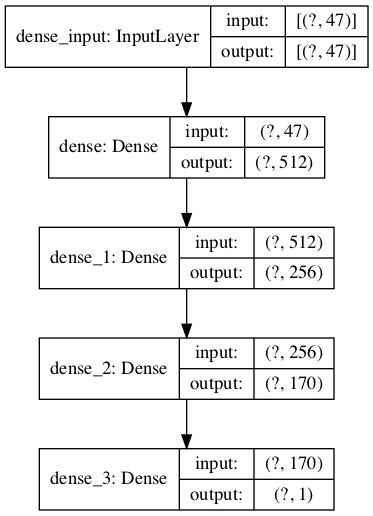

In [48]:
# Darstellung der Architektur des KNN-Regressionsmodell
plot_model(seq_model, 'Images/Sequential Regression Model.png', show_shapes=True)

In [49]:
history = seq_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, callbacks=[es])
#history = seq_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, callbacks=[red_lr])
#history = seq_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, callbacks=[es, red_lr])
#history = seq_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs)

Epoch 1/300
1385/1385 [==============================] - 3s 2ms/step - loss: 10601720832.0000 - mse: 10601720832.0000 - rmse: 102964.6562 - mae: 47512.3203 - val_loss: 6680989184.0000 - val_mse: 6680989184.0000 - val_rmse: 81737.3203 - val_mae: 38908.5547
Epoch 2/300
1385/1385 [==============================] - 3s 2ms/step - loss: 6822854144.0000 - mse: 6822854144.0000 - rmse: 82600.5703 - mae: 38591.8398 - val_loss: 6540531712.0000 - val_mse: 6540531712.0000 - val_rmse: 80873.5547 - val_mae: 39490.5195
Epoch 3/300
1385/1385 [==============================] - 3s 2ms/step - loss: 6631455744.0000 - mse: 6631455744.0000 - rmse: 81433.7500 - mae: 38156.0742 - val_loss: 6392665600.0000 - val_mse: 6392665600.0000 - val_rmse: 79954.1484 - val_mae: 38214.1484
Epoch 4/300
1385/1385 [==============================] - 3s 2ms/step - loss: 6555120128.0000 - mse: 6555120128.0000 - rmse: 80963.6953 - mae: 37850.8516 - val_loss: 6346155008.0000 - val_mse: 6346155008.0000 - val_rmse: 79662.7578 - val_m

1385/1385 [==============================] - 3s 2ms/step - loss: 5914561536.0000 - mse: 5914561536.0000 - rmse: 76906.1875 - mae: 36126.2422 - val_loss: 6015988736.0000 - val_mse: 6015988736.0000 - val_rmse: 77562.8047 - val_mae: 37926.3398
Epoch 34/300
1385/1385 [==============================] - 3s 2ms/step - loss: 5901267968.0000 - mse: 5901267968.0000 - rmse: 76819.7109 - mae: 36161.2969 - val_loss: 6255358976.0000 - val_mse: 6255358976.0000 - val_rmse: 79090.8281 - val_mae: 37920.3086
Epoch 35/300
1385/1385 [==============================] - 3s 2ms/step - loss: 5902809088.0000 - mse: 5902809088.0000 - rmse: 76829.7422 - mae: 36097.8477 - val_loss: 6113753088.0000 - val_mse: 6113753088.0000 - val_rmse: 78190.4922 - val_mae: 37293.6836
Epoch 36/300
1385/1385 [==============================] - 3s 2ms/step - loss: 5867488256.0000 - mse: 5867488256.0000 - rmse: 76599.5312 - mae: 36044.7930 - val_loss: 5988302848.0000 - val_mse: 5988302848.0000 - val_rmse: 77384.1250 - val_mae: 35563.73

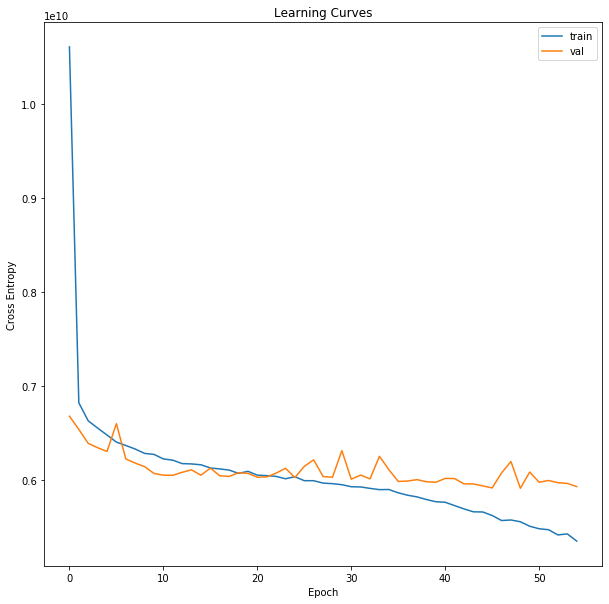

In [50]:
# Darstellung der Lernkurve (Trainingsdatenfehler vs. Testdatenfehler)
plt.figure(figsize=(10,10))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title('Learning Curves')
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy')
plt.legend()
plt.show()

In [51]:
# Evaluation des Regressionsmodells
error = seq_model.evaluate(X_test, y_test)

594/594 [==============================] - 1s 974us/step - loss: 5933878784.0000 - mse: 5933878784.0000 - rmse: 77031.6719 - mae: 35095.1523


Text(0, 0.5, 'Vorhergesagte Werte (Test Daten)')

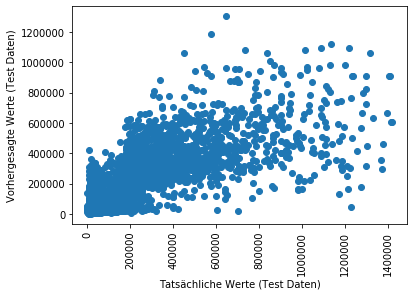

In [53]:
# Scatter Plot mit den tatsächlichen und den vorhergesagten Daten für die Test Data

predictions= seq_model.predict(X_test)
plt.plot(y_test, predictions, 'o')
plt.xlabel('Tatsächliche Werte (Test Daten)')
plt.xticks(rotation=90)
plt.ylabel('Vorhergesagte Werte (Test Daten)')

Text(0, 0.5, 'Vorhergesagte Werte (Trainings Daten)')

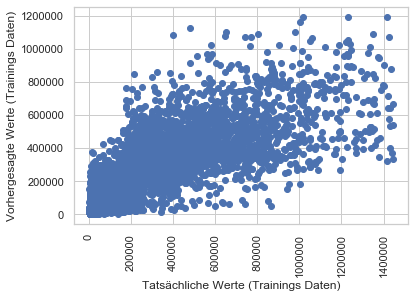

In [103]:
# Scatter Plot mit den tatsächlichen und den vorhergesagten Daten für die Training Data
train_predictions=seq_model.predict(X_train)
plt.plot(y_train, train_predictions, 'o')
plt.xlabel('Tatsächliche Werte (Trainings Daten)')
plt.xticks(rotation=90)
plt.ylabel('Vorhergesagte Werte (Trainings Daten)')

In [54]:
# Berechnung des R2-Scores (Bestimmtheitsmaß)
r2_seq = r2_score(y_test, predictions)
r2_seq

0.6845000722870389

In [55]:
# Berechnung des adjustierten R2-Scores (adj. Bestimmtheitsmaß)
adj_r2_seq = 1-(1-r2_seq)*((len(X_test)-1)/(len(X_test)-(len(cat)+len(con))))

In [56]:
print(('R2: %.6f \t Adj. R2: %.6f \t RMSE: %.0f  \t MSE: %.0f \t MAE: %.0f' % 
      (r2_seq, adj_r2_seq, error[2], error[1], error[3])).replace('.', ','))

0,684500 	 0,684201 	 77032  	 5933878784 	 35095


In [58]:
predictions = predictions.flatten()

In [59]:
train_predictions = train_predictions.flatten()

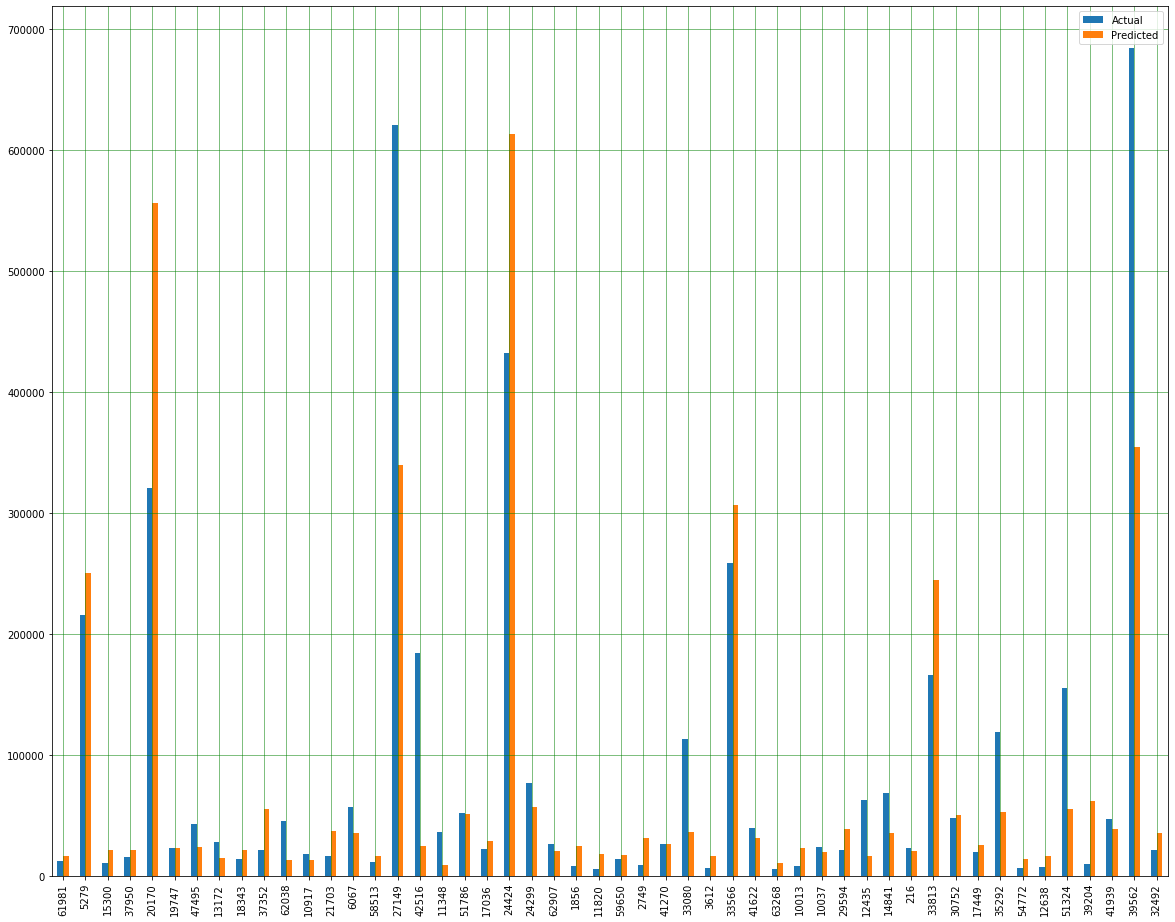

In [60]:
pred = pd.DataFrame({'Actual': y_test, 'Predicted': predictions})
pred1 = pred.sample(50)

pred1.plot(kind='bar',figsize=(20,16))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

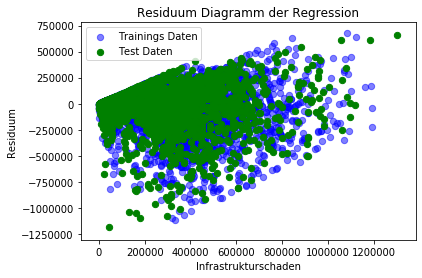

In [61]:
# Differenzen zwischen vorhergesagten und tatsächlichen Werten
plt.scatter(train_predictions, train_predictions - y_train, c='b', s=40, alpha=0.5, label='Trainings Daten')
plt.scatter(predictions, predictions - y_test, c='g', s=40, label='Test Daten')
plt.hlines(y=0, xmin=-0.03, xmax=0.2)
plt.title('Residuum Diagramm der Regression')
plt.ylabel('Residuum')
plt.xlabel('Infrastrukturschaden')
plt.legend()
plt.show()

## Functional API Regression Model with Keras

In [62]:
# Funktion zur Erstellung eines KNN-Regressionmodells mit der Keras Functional API
def create_func_model(learning_rate = 0.001, activation = 'relu', activation2='relu', dropout=0, hidden_layers=2, initital_neurons=n_features):
    x_in = Input(shape=(n_features,))
    dense = Dense(int(initital_neurons), activation=activation)
    x = dense(x_in)
    if (dropout > 0):    
        x = Dropout(dropout)(x)
    if (hidden_layers > 1):
        i=1
        hidden_neurons = int(initital_neurons)
        while (i<=(hidden_layers-1)):
            neurons = int(hidden_neurons/(i+1))
            if (neurons <= 0):
                neurons = n_features
            x = Dense(neurons, activation=activation2)(x)
            if (dropout > 0):    
                x = Dropout(dropout)(x)
            i+=1
    x_out = Dense(1)(x)
    func_model = Model(inputs=x_in, outputs=x_out)
    return func_model

In [63]:
# Erstellung des KNN Regressionsmodell mit der Keras Functional API
func_model = create_func_model(learning_rate=learning_rate, activation=activation, activation2=activation2, dropout=dropout, hidden_layers=hidden_layers, initital_neurons=neurons)

In [64]:
func_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 47)]              0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               24576     
_________________________________________________________________
dense_5 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_6 (Dense)              (None, 170)               43690     
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 171       
Total params: 199,765
Trainable params: 199,765
Non-trainable params: 0
_________________________________________________________________


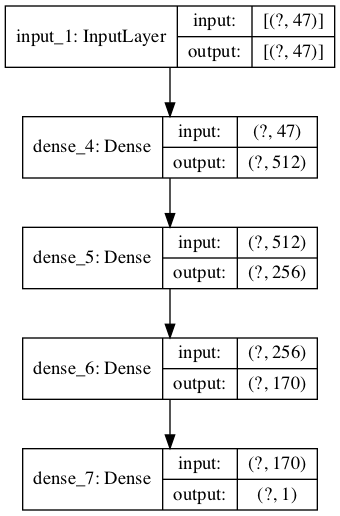

In [65]:
# Erstellung der KNN Architektur
plot_model(func_model, 'Images/Functional API Regression Model.png', show_shapes=True)

In [66]:
# Festlegen des Optimizers und der Regressionsmetriken
func_model.compile(optimizer=opt, loss='mse', metrics=metrics)

In [67]:
func_history = func_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, callbacks=[es])
#func_history = func_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, callbacks=[red_lr])
#func_history = func_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, callbacks=[es, red_lr])
#func_history = func_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=32)

Epoch 1/300
1385/1385 [==============================] - 3s 2ms/step - loss: 8427123200.0000 - mse: 8427123200.0000 - rmse: 91799.3672 - mae: 42583.8359 - val_loss: 6533840896.0000 - val_mse: 6533840896.0000 - val_rmse: 80832.1797 - val_mae: 39185.7773
Epoch 2/300
1385/1385 [==============================] - 3s 2ms/step - loss: 6811244544.0000 - mse: 6811244544.0000 - rmse: 82530.2656 - mae: 38544.6719 - val_loss: 6397197312.0000 - val_mse: 6397197312.0000 - val_rmse: 79982.4844 - val_mae: 37451.6836
Epoch 3/300
1385/1385 [==============================] - 3s 2ms/step - loss: 6630501376.0000 - mse: 6630501376.0000 - rmse: 81427.8906 - mae: 38036.9648 - val_loss: 6334534144.0000 - val_mse: 6334534144.0000 - val_rmse: 79589.7891 - val_mae: 37429.2422
Epoch 4/300
1385/1385 [==============================] - 3s 2ms/step - loss: 6518535168.0000 - mse: 6518535168.0000 - rmse: 80737.4453 - mae: 37776.2070 - val_loss: 6282547712.0000 - val_mse: 6282547712.0000 - val_rmse: 79262.5234 - val_mae:

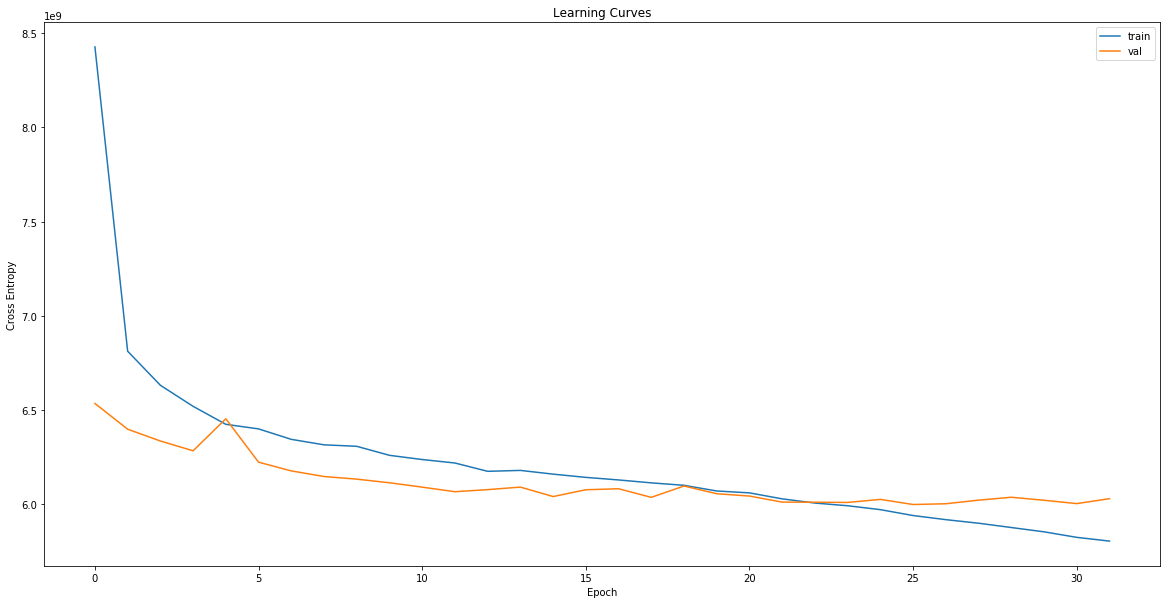

In [68]:
# Darstellung der Lernkurve (Trainingsdatenfehler vs. Testdatenfehler)
plt.figure(figsize=(20,10))
plt.plot(func_history.history['loss'], label='train')
plt.plot(func_history.history['val_loss'], label='val')
plt.title('Learning Curves')
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy')
plt.legend()
plt.show()

Text(0, 0.5, 'Vorhergesagte Werte (Test Daten)')

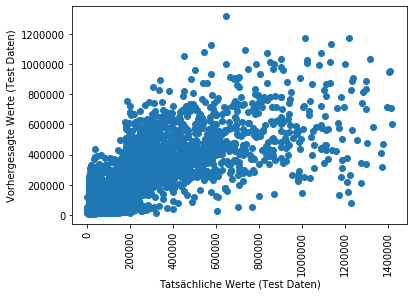

In [70]:
# Scatter Plot mit den tatsächlichen und den vorhergesagten Daten für die Test Data
func_predictions=func_model.predict(X_test)
plt.plot(y_test, func_predictions, 'o')
plt.xlabel('Tatsächliche Werte (Test Daten)')
plt.xticks(rotation=90)
plt.ylabel('Vorhergesagte Werte (Test Daten)')

Text(0, 0.5, 'Vorhergesagte Werte (Trainings Daten)')

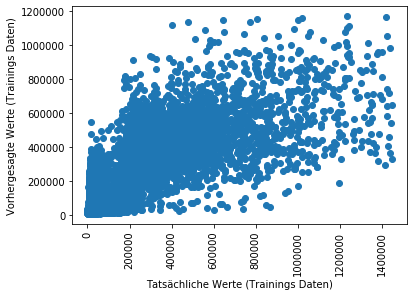

In [74]:
# Scatter Plot mit den tatsächlichen und den vorhergesagten Daten für die Training Data
func_train_predictions=func_model.predict(X_train)
plt.plot(y_train, func_train_predictions, 'o')
plt.xlabel('Tatsächliche Werte (Trainings Daten)')
plt.xticks(rotation=90)
plt.ylabel('Vorhergesagte Werte (Trainings Daten)')

In [105]:
# Evaluation des Regressionsmodells
error_func = func_model.evaluate(X_test, y_test, verbose=0)

In [71]:
# Berechnung des R2-Scores (Bestimmtheitsmaß)
r2_func = r2_score(y_test, func_predictions)
r2_func

0.6794783073353972

In [72]:
# Berechnung des adjustierten R2-Scores (adj. Bestimmtheitsmaß)
adj_r2_func = 1-(1-r2_func)*((len(X_test)-1)/(len(X_test)-(len(cat)+len(con))))
adj_r2_func

0.6791740948140176

In [104]:
print(('R2: %.6f \t Adj. R2: %.6f \t RMSE: %.0f  \t MSE: %.0f \t MAE: %.0f' % 
      (r2_func, adj_r2_func, error_func[2], error_func[1], error_func[3])).replace('.', ','))

R2: 0,679478 	 Adj, R2: 0,679174 	 RMSE: 77642  	 MSE: 6028323328 	 MAE: 35899


In [75]:
func_predictions = func_predictions.flatten()

In [76]:
func_train_predictions = func_train_predictions.flatten()

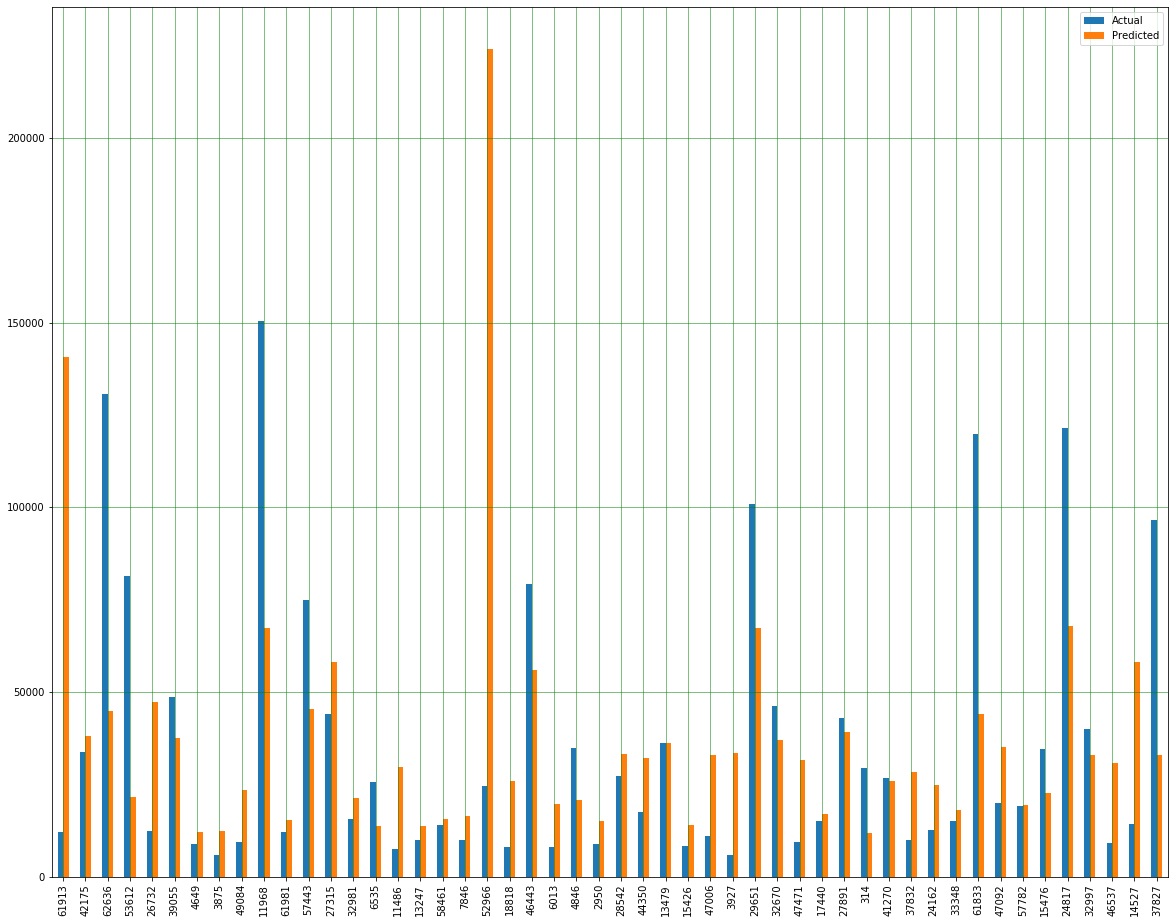

In [77]:
pred = pd.DataFrame({'Actual': y_test, 'Predicted': func_predictions})
pred1 = pred.sample(50)

pred1.plot(kind='bar',figsize=(20,16))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

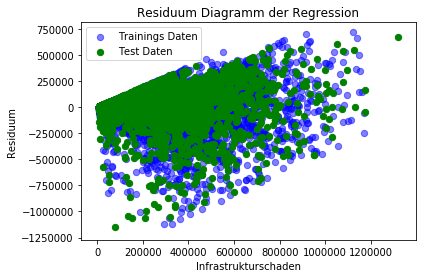

In [78]:
# Differenzen zwischen vorhergesagten und tatsächlichen Werten
plt.scatter(func_train_predictions, func_train_predictions - y_train, c='b', s=40, alpha=0.5, label='Trainings Daten')
plt.scatter(func_predictions, func_predictions - y_test, c='g', s=40, label='Test Daten')
plt.hlines(y=0, xmin=-0.03, xmax=0.2)
plt.title('Residuum Diagramm der Regression')
plt.ylabel('Residuum')
plt.xlabel('Infrastrukturschaden')
plt.legend()
plt.show()

##  Regression with Scikit-Learn

In [79]:
def get_rmse_r2(mod, X_test, y_Test):
    y_pred = mod.predict(X_test)
    r2 = r2_score(y_Test, y_pred)
    adj_r2 = 1-(1-r2)*((len(X_test)-1)/(len(X_test)-(len(cat)+len(con))))
    mae = mean_absolute_error(y_Test, y_pred)
    return np.sqrt(mean_squared_error(y_Test, y_pred)), mae, r2, adj_r2, mod.__class__.__name__

In [80]:
d_rmse = dict()
d_mae = dict()
d_r2 = dict()
d_adj_r2 = dict()

In [81]:
# Vergleich mit Linearer Regression
lr = LinearRegression().fit(X_train, y_train)
rmse, mae, r2, adj_r2, lr_name = get_rmse_r2(lr, X_test, y_test)
d_rmse['Linear Regression'] = [rmse]
d_mae['Linear Regression'] = [mae]
d_r2['Linear Regression'] = [r2]
d_adj_r2['Linear Regression'] = [adj_r2]
print ('(' + lr_name + ') RMSE:', rmse, ' MAE:', mae, ' R2:' , r2, 'Adjusted R2:', adj_r2)

(LinearRegression) RMSE: 91676.10982671703  MAE: 48909.049199325746  R2: 0.5531383200069478 Adjusted R2: 0.5527141960818291


In [82]:
# Vergleich mit Ridge Regression
ridge = Ridge(random_state=0).fit(X_train, y_train)
rmse, mae, r2, adj_r2, ridge_name = get_rmse_r2(ridge, X_test, y_test)
d_rmse['Ridge Regression'] = [rmse]
d_mae['Ridge Regression'] = [mae]
d_r2['Ridge Regression'] = [r2]
d_adj_r2['Ridge Regression'] = [adj_r2]
print ('(' + ridge_name + ') RMSE:', rmse, ' MAE:', mae, ' R2:' , r2, 'Adjusted R2:', adj_r2)

(Ridge) RMSE: 91655.62328635743  MAE: 48901.301379374425  R2: 0.5533380149325028 Adjusted R2: 0.5529140805411916


In [83]:
# Vergleich mit Lasso Regression
lasso = Lasso(random_state=0).fit(X_train, y_train)
rmse, mae, r2, adj_r2, lasso_name = get_rmse_r2(lasso, X_test, y_test)
d_rmse['Lasso Regression'] = [rmse]
d_mae['Lasso Regression'] = [mae]
d_r2['Lasso Regression'] = [r2]
d_adj_r2['Lasso Regression'] = [adj_r2]
print ('(' + lasso_name + ') RMSE:', rmse, ' MAE:', mae, ' R2:' , r2, 'Adjusted R2:', adj_r2)

(Lasso) RMSE: 91655.02731024406  MAE: 48899.49776165834  R2: 0.553343823610658 Adjusted R2: 0.552919894732461


In [84]:
# Vergleich mit Elastic Net Regression
en = ElasticNet(random_state=0, alpha=0.2).fit(X_train, y_train)
rmse, mae, r2, adj_r2, en_name = get_rmse_r2(en, X_test, y_test)
d_rmse['Elastic Net Regression'] = [rmse]
d_mae['Elastic Net Regression'] = [mae]
d_r2['Elastic Net Regression'] = [r2]
d_adj_r2['Elastic Net Regression'] = [adj_r2]
print ('(' + en_name + ') RMSE:', rmse, ' MAE:', mae, ' R2:' , r2, 'Adjusted R2:', adj_r2)

(ElasticNet) RMSE: 95540.17849880808  MAE: 48727.15337926642  R2: 0.5146747821056137 Adjusted R2: 0.5142141517907126


In [85]:
d_rmse['Neuronale Netzwerk Regression']=[error[2]]
d_mae['Neuronale Netzwerk Regression']=[error[3]]
d_r2['Neuronale Netzwerk Regression']=[r2_seq]
d_adj_r2['Neuronale Netzwerk Regression']=[adj_r2_seq]

In [94]:
# Funktion zur Beschriftung der Säulen
def bar_values(ax, scoretype = 'Default'):
    for p in ax.patches:
        if (scoretype == 'RMSE' or scoretype =='MAE'):
            ax.annotate(format(p.get_height(), ',.0f').replace(",","."), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), fontsize=16, textcoords = 'offset points')
        else:
            ax.annotate(format(p.get_height(), ',.4f').replace(",","."), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), fontsize=16, textcoords = 'offset points')
    return ax

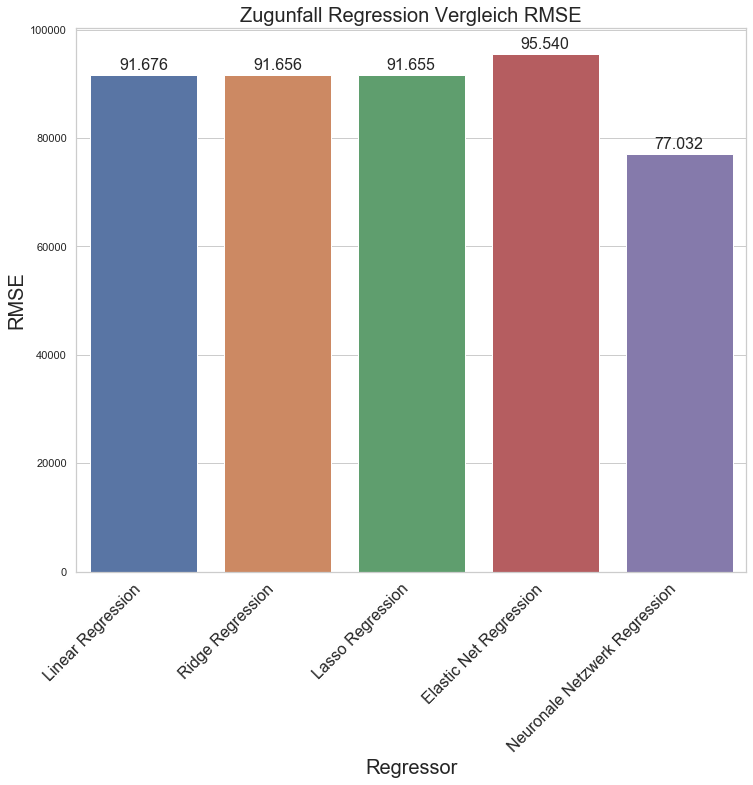

In [100]:
# Diagrammerstellung mit den RMSE Werten
algo, rmse = [], []
for key, value in d_rmse.items():
    algo.append(key)
    rmse.append(value[0]) 
plt.figure('RMSE', figsize=(12,10)) 
sns.set(style="whitegrid")
ax = sns.barplot(algo, rmse)
ax = bar_values(ax, 'RMSE')
plt.title('Zugunfall Regression Vergleich RMSE', fontsize=20)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right', fontsize=16)
plt.xlabel('Regressor', fontsize=20) 
plt.ylabel('RMSE', fontsize=20) 
plt.savefig('Images/Regression/RMSE_Vergleich.png', bbox_inches='tight')
plt.show()

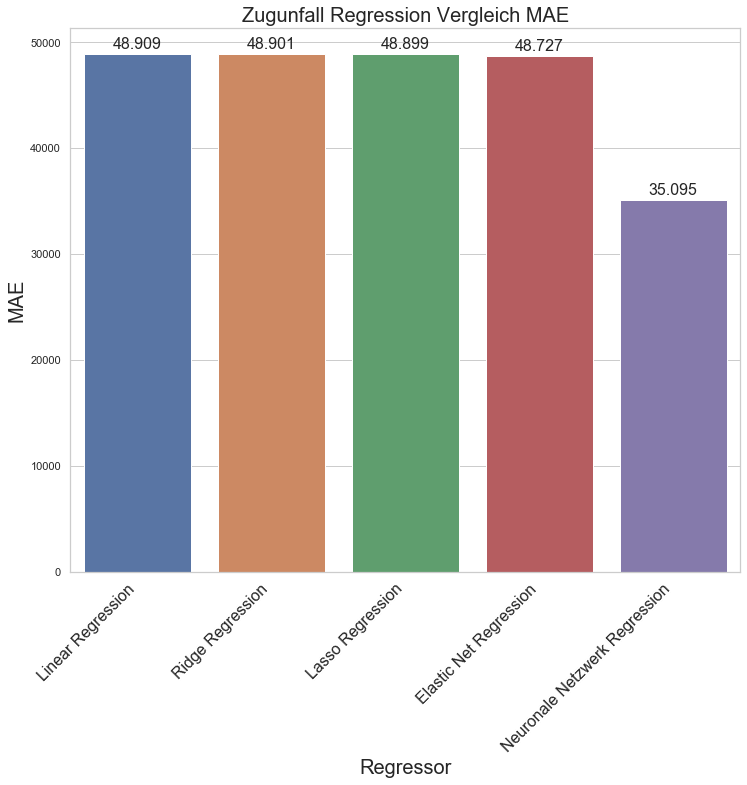

In [99]:
# Diagrammerstellung mit den MAE Werten
mae_algo, mae = [], []
for key, value in d_mae.items():
    mae_algo.append(key)
    mae.append(value[0]) 
plt.figure('MAE', figsize=(12,10)) 
sns.set(style="whitegrid")
ax = sns.barplot(mae_algo, mae)
ax = bar_values(ax, 'MAE')
plt.title('Zugunfall Regression Vergleich MAE', fontsize=20)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right', fontsize=16)
plt.xlabel('Regressor', fontsize=20) 
plt.ylabel('MAE', fontsize=20) 
plt.savefig('Images/Regression/MAE_Vergleich.png', bbox_inches='tight')
plt.show()

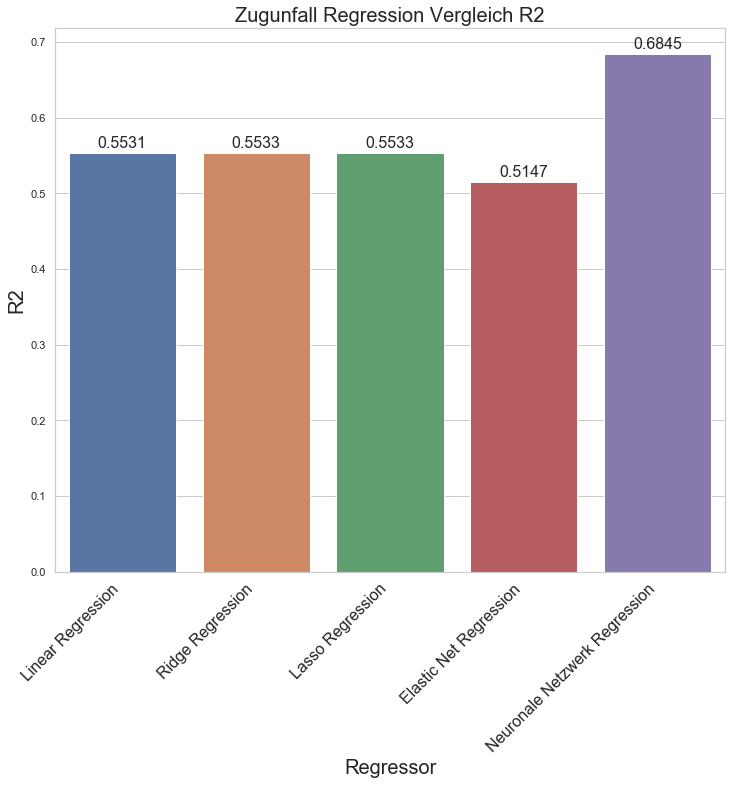

In [98]:
# Diagrammerstellung mit den R2 Werten
r2_algo, r2 = [], []
for key, value in d_r2.items():
    r2_algo.append(key)
    r2.append(value[0]) 
plt.figure('R2', figsize=(12,10)) 
sns.set(style="whitegrid")
ax = sns.barplot(r2_algo, r2) 
ax = bar_values(ax)
plt.title('Zugunfall Regression Vergleich R2', fontsize=20)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right', fontsize=16)
plt.xlabel('Regressor', fontsize=20) 
plt.ylabel('R2', fontsize=20) 
plt.savefig('Images/Regression/R2_Vergleich.png', bbox_inches='tight')
plt.show()

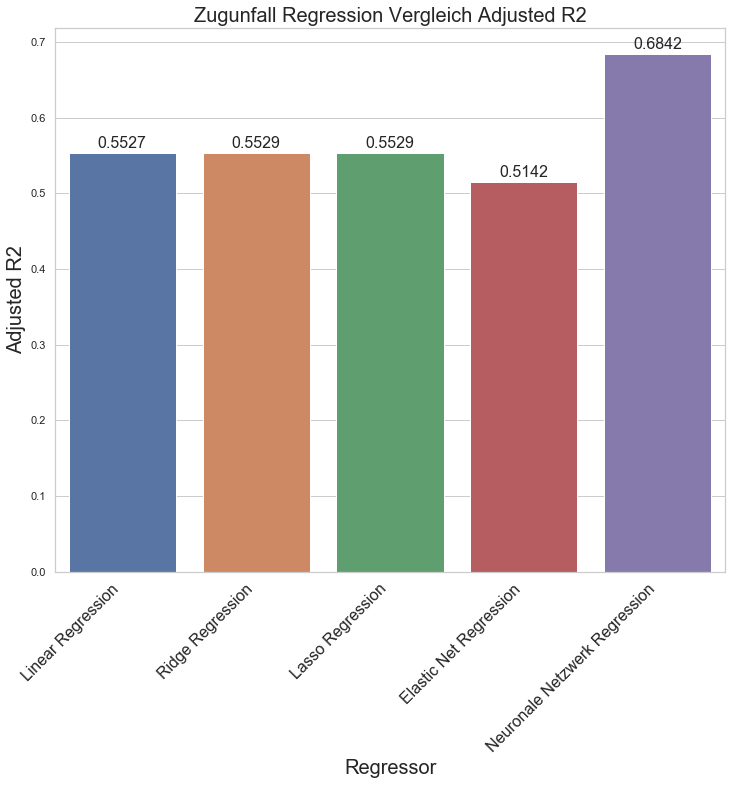

In [101]:
# Diagrammerstellung mit den Adj. R2 Werten
adj_r2_algo, adj_r2 = [], []
for key, value in d_adj_r2.items():
    adj_r2_algo.append(key)
    adj_r2.append(value[0]) 
plt.figure('Adjusted R2', figsize=(12,10)) 
sns.set(style="whitegrid")
ax = sns.barplot(adj_r2_algo, adj_r2) 
ax = bar_values(ax)
plt.title('Zugunfall Regression Vergleich Adjusted R2', fontsize=20)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right', fontsize=16)
plt.xlabel('Regressor', fontsize=20) 
plt.ylabel('Adjusted R2', fontsize=20) 
plt.savefig('Images/Regression/Adj_R2_Vergleich.png', bbox_inches='tight')
plt.show()